# The quintic Ornstein-Uhlenbeck model VIX iv

In [1]:
import pandas as pd
import BlackScholes as bs
import variance_curve as vc
import risk_free_rates as rf
import implied_q as iq
import time
import scipy
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy import interpolate
from scipy.optimize import least_squares as ls
from scipy.integrate import quad
from matplotlib import cm

In [2]:
def horner_vector(poly, n, x):
    #Initialize result
    result = poly[0].reshape(-1,1)
    for i in range(1,n):
        result = result*x + poly[i].reshape(-1,1)
    return result

In [3]:
def gauss_dens(mu,sigma,x):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

In [4]:
def vix_iv(H, eps, T, a_k_part, K, r, q, n_steps):

    a2,a4 = (0,0)
    a0,a1,a3,a5 = a_k_part
    a_k = np.array([a0, a1, a2, a3, a4, a5])
    
    kappa_tild = (0.5-H)/eps
    eta_tild = eps**(H-0.5)

    delt = 30/365
    T_delta = T + delt

    std_X = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*T)))
    dt = delt/(n_steps)
    tt = np.linspace(T, T_delta, n_steps+1)
    
    FV_curve_all_vix = vc.variance_curve(tt)
    
    exp_det = np.exp(-kappa_tild*(tt-T))
    cauchy_product = np.convolve(a_k,a_k)
    
    std_Gs_T = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*(tt-T))))
    std_X_t = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*tt)))
    std_X_T = std_X
    
    n = len(a_k)
    
    normal_var = np.sum(cauchy_product[np.arange(0,2*n,2)].reshape(-1,1)*std_X_t**(np.arange(0,2*n,2).reshape(-1,1))*\
    scipy.special.factorial2(np.arange(0,2*n,2).reshape(-1,1)-1),axis=0) #g(u)
    
    beta = []
    for i in range(0,2*n-1):
        k_array = np.arange(i,2*n-1)
        beta_temp = ((std_Gs_T**((k_array-i).reshape(-1,1))*((k_array-i-1)%2).reshape(-1,1)*\
            scipy.special.factorial2(k_array-i-1).reshape(-1,1)*\
            (scipy.special.comb(k_array,i)).reshape(-1,1))*\
            exp_det**(i))*cauchy_product[k_array].reshape(-1,1)
        beta.append(np.sum(beta_temp,axis=0))

    beta = np.array(beta)*FV_curve_all_vix/normal_var
    beta = (np.sum((beta[:,:-1]+beta[:,1:])/2,axis=1))*dt
    
    sigma = np.sqrt(eps**(2*H)/(1-2*H)*(1-np.exp((2*H-1)*T/eps)))
    
    N = len(K); P = np.zeros(N);
    
    for i in range(N):
    
        f = lambda x: np.maximum(np.sqrt(horner_vector(beta[::-1], len(beta), x)/delt)*100 - K[i], 0) * gauss_dens(0, sigma, x)
        P[i], err = quad(f, -np.inf, np.inf)
    
    return P * np.exp((r-q)*T)

In [2]:
data = pd.read_csv("vix_opt.csv")
vix_T = np.array(data["Exp Date"])[2:13]
IV = np.array(data.iloc[:,2:])[2:13,:]/100
k = np.array([80, 90, 95, 97.5, 100, 102.5, 105, 110, 120])/100
S0 = 19.81
K = S0 * k

In [26]:
vix_T = np.append(vix_T[:2], vix_T[3:])
nr = len(vix_T); nc = len(k);
IV = np.append(IV[:2,:], IV[3:,:]).reshape((nr,nc))

In [28]:
N = len(vix_T); drift = np.zeros(N);
R = np.zeros(N); Q = np.zeros(N);

for i in range(N):
    T = vix_T[i]; F = vix_f[i];
    drift[i] = -np.log(S0/F)/T
    R[i] = rf.r(T)
    Q[i] = R[i] - drift[i]

In [29]:
nr = len(vix_T); nc = len(k); n = 2000;
inp = np.array([ 0.2, 0.01, 1, 0.01, 0.02, 0.05]) #H,eps,a0,a1,a3,a5
bnds = ([-0.1, 1e-10, 0, 0, 0, 0],[0.5, 0.5, np.inf, np.inf, np.inf, np.inf])
IV = IV[:nr, :]; vol = IV.flatten();
start_all = time.time()

def h(x):
    H,eps,a0,a1,a3,a5 = x
    a_k = np.array([a0, a1, a3, a5])
    iv = np.zeros([nr,nc])
    for i in range(nr):
        T = vix_T[i]; r = R[i]; q = Q[i];
        P = vix_iv(H, eps, T, a_k, K, r, q, n)
        iv[i,:] = bs.BSImpliedVol(S0, K, T, r, q, P, 1, 1e-10)
    
    return iv
        
def f(x):
    return h(x).flatten() - vol
    
res = ls(f, inp, bounds = bnds, max_nfev = 20, ftol = 1e-15, gtol = 1e-15, xtol = 1e-15)
model_param = res.x
model_iv = h(res.x)
    
print(f'Total elapsed time: {time.time()-start_all: .0f} s')

print(f'\nMean percentage error: {np.mean(np.abs(model_iv-IV)/IV)*100: .4f}%')

Total elapsed time:  674 s

Mean percentage error:  8.7636%


In [3]:
model_iv = np.array(pd.read_csv("quintic_global_vix_iv.csv"))

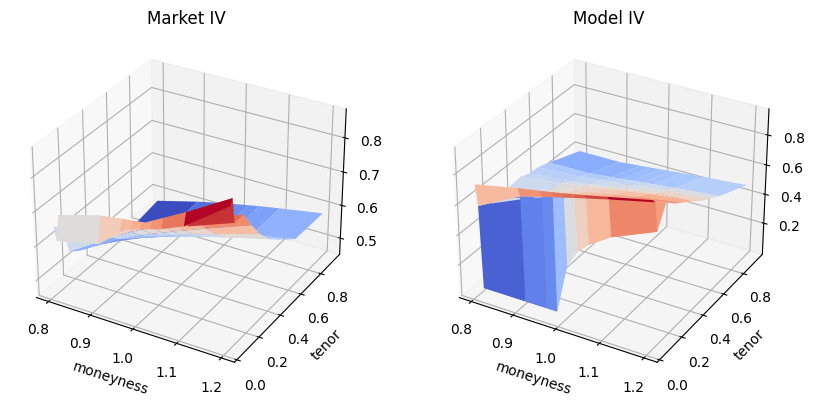

In [4]:
mesh_x, mesh_y = np.meshgrid(k, vix_T)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

ax1 = fig.add_subplot(121,projection='3d')
surf1 = ax1.plot_surface(mesh_x, mesh_y, IV, cmap=cm.coolwarm, antialiased=True)
ax1.set_xlabel('moneyness')
ax1.set_ylabel('tenor')
ax1.set_title('Market IV')

ax2 = fig.add_subplot(122,projection='3d')
surf2 = ax2.plot_surface(mesh_x, mesh_y, model_iv, cmap=cm.coolwarm, antialiased=True)
ax2.set_xlabel('moneyness')
ax2.set_ylabel('tenor')
#ax2.set_zlabel('IV Calibrated')
ax2.set_title('Model IV')

plt.show()

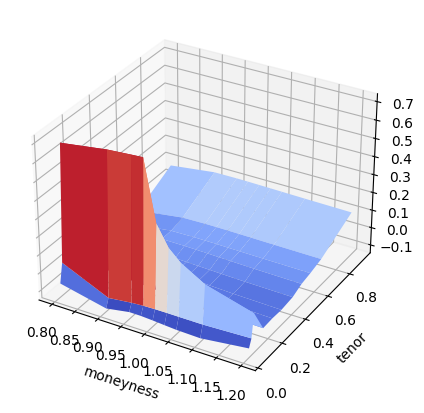

In [5]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_figheight(5)
fig.set_figwidth(15)

surf = ax.plot_surface(mesh_x, mesh_y, IV-model_iv, cmap=cm.coolwarm, antialiased=True)
ax.set_xlabel('moneyness')
ax.set_ylabel('tenor')
#ax1.set_title('Market IV')

plt.show()

In [17]:
df = pd.DataFrame(model_param.reshape((1,6)), columns = ["H", "eps", "a0", "a1", "a3", "a5"])
df.to_csv("quintic_global_param_vix_iv.csv", index = False)
db = pd.DataFrame(model_iv)
db.to_csv("quintic_global_vix_iv.csv", index = False)